In [2]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../../figures/SI/cell_cycle"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png",".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use('../bursa.mplstyle')
sns.set_style("ticks")

In [3]:
%run ../helper.py

In [4]:
# Tabula Bursa B cells with IgH assemblies
adata = sc.read_h5ad('../../../data/bcells.h5ad.gz', backed='r')

In [5]:
# get data for plotting
obs = sc.get.obs_df(adata, keys=['MKI67', 'celltypist', "corr_cycling", "correlation_cycling"])
dict_name = "bcelltype_colors_full"
data = obs[obs.celltypist.isin(color_dicts.get_colors(dict_name).keys())]
data.celltypist = data.celltypist.cat.remove_unused_categories()
palette = color_dicts.get_colors(dict_name)

/tmp/ipykernel_87678/1883223691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.celltypist = data.celltypist.cat.remove_unused_categories()


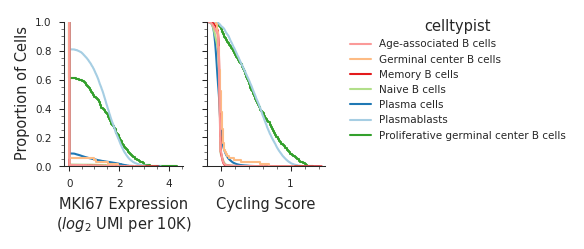

In [6]:
fig, axs = plt.subplots(1,2, figsize = (2.25, 1.25), sharey=True)

GOI = "MKI67"
# MKI67 expression
sns.ecdfplot(data, x = GOI, hue = 'celltypist', ax = axs[0], complementary=True, palette=palette, log_scale=(False, False), legend = False)
#sns.move_legend(axs[0], loc='right', bbox_to_anchor = (2,0.6))
axs[0].set_xlabel(f"{GOI} Expression\n($log_2$ UMI per 10K)")
axs[0].set_ylabel("")
# cycling score
sns.ecdfplot(data, x = 'correlation_cycling', hue = 'celltypist', ax = axs[1], complementary=True, palette=palette, log_scale=(False, False))
sns.move_legend(axs[1], loc='right', bbox_to_anchor = (3.1,0.6))
axs[1].set_xlabel("Cycling Score")
axs[1].set_ylabel("")
fig.supylabel("Proportion of Cells", x = -0.02, fontsize = 7)

axs[1].set_xlim(-0.2,1.5)
plt.subplots_adjust(
                    hspace=0.6)

sns.despine()
save_figure(fig, f"{GOI}_CCscore_celltypist_ecdf")

## Test cell cycling scoring on different truth dataset

In [7]:
adata = adata[adata.obs.sample(n=20000, replace=False).index].to_memory()
df = adata.to_df()
# convert cell x gene matrix to df
#df = convert_sparse_to_dataframe(adata)
# Use Numpy to do the Pearson Correllation of all values
# Did this because pandas corr is very slow, must be a bug.. 
# rowvar false means that genes are being correllated
df_corr = np.corrcoef(df.values, rowvar=False) 
# Put the labels back on and make it a df
df_corr = pd.DataFrame(df_corr, index = df.columns, columns=df.columns)
# Check that the matrix looks correct
df_corr.head()
GOI = 'MKI67'

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# arbitrary cutoffs for Pearson correlation (using rank order anyhow)
cutoff = 0.3
cutoff_neg = -0.2
# all above cutoff
cell_cycle_genes = list(df_corr[df_corr[GOI] > cutoff][GOI].sort_values(ascending = False).index)
anti_cell_cycle_genes = list(df_corr[df_corr[GOI] < cutoff_neg][GOI].sort_values(ascending = False).index)
# balance the total amounts of each gene type
total_cc = len(cell_cycle_genes)
total_acc = len(anti_cell_cycle_genes)
if  total_cc <= total_acc:
    anti_cell_cycle_genes = anti_cell_cycle_genes[:total_cc]
else:
    cell_cycle_genes = cell_cycle_genes[:total_acc] 
# construct df to hold gene feature set 
cc = pd.DataFrame([cell_cycle_genes, anti_cell_cycle_genes]).T
cc.columns = ['cc', 'anti_cc']
cc.to_csv('cell_cycle_genes.tab', sep = "\t")
cell_cycle_genes = pd.read_table('cell_cycle_genes.tab', index_col=0)

# Show Validation of scoring / calibaration of threshold on dataset of known to be cycling B cells

In [9]:
adata = sc.read_h5ad('/home/michaelswift/repos/seqclone3/analysis/processed_data/h5ad_objects/bcells.h5ad')
adata.obs_names_make_unique(join="_")

In [10]:
cell_cycle_genes = pd.read_table('/home/michaelswift/repos/tabula-bursa/analysis/notebooks/cell_cycle/cell_cycle_genes.tab', index_col=0)

In [11]:
# label cycling and non-cycling via aggregate score of cell cycle correlated genes
same_length = False
genes_contributing_to_score = 30
if same_length:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'anti_cc'], score_name='anticorrelation_cycling')
else:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'anti_cc'], score_name='anticorrelation_cycling')


adata.obs['corr_cycling'] = adata.obs['correlation_cycling'] > 0.05
adata.obs['anticorr_cycling'] = adata.obs['anticorrelation_cycling'] > 0.4

cycling_mapper = {True:'True', False:'False'}

non_cycling = False
if non_cycling:
    adata.obs['cycling'] = adata.obs['anticorr_cycling'].map(cycling_mapper)
else:
    adata.obs['cycling'] = adata.obs['corr_cycling'].map(cycling_mapper)

In [12]:
_adata = adata[(adata.obs.sample_uid == "L04_T4") | (adata.obs.sample_uid == 'L01_Input')]

In [13]:
sample_cycling_dict = {"L04_T4": "cycling B cells", "L01_Input": "resting B cells"}

In [14]:
_adata.obs.loc[:," "] = _adata.obs.sample_uid.map(sample_cycling_dict).values

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


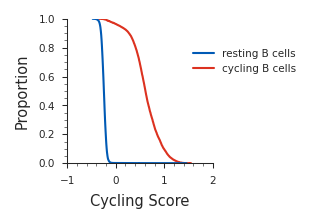

In [15]:
fig, ax = plt.subplots(1,1, figsize = (1.25,1.25)) 
sns.ecdfplot(data = _adata.obs, x = 'correlation_cycling', hue = ' ', complementary = True, log_scale=(False,False), palette = {'resting B cells': '#005AB5', 'cycling B cells': '#DC3220'})
ax.set_xlabel("Cycling Score")
ax.set_xlim(-1,2)
sns.despine(fig)
sns.move_legend(ax, bbox_to_anchor=(0.8, 1), loc='upper left')
save_figure(fig, "ecdf_LSAdata_cycling")

In [16]:
sc.metrics.confusion_matrix(_adata.obs[' '], _adata.obs['cycling'], normalize=True)

cycling,False,True
,,
resting B cells,0.999307,0.000693
cycling B cells,0.044897,0.955103


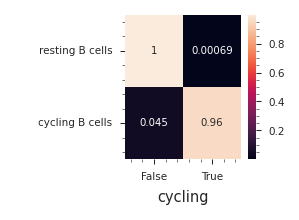

: 

In [17]:

fig, ax = plt.subplots(1,1, figsize = (1.25,1.25))

sns.heatmap(sc.metrics.confusion_matrix(_adata.obs[' '], _adata.obs['cycling'], normalize=True), annot=True, annot_kws={"fontsize":"x-small"}, ax = ax)

save_figure(fig, "confusion_matrix_cell_cycle_Swift2023")